In [1]:
#error message 제거
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
IMAGE_PATH = '/home/jwjang/project_tf28/resize_image/'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

valid_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 14452 images belonging to 8 classes.
Found 3608 images belonging to 8 classes.


In [5]:
image_batch, label_batch = next(valid_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 8))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('can_labels.txt', 'w') as f:
  f.write(labels)

{'chilsung_cider': 0, 'coca_cola': 1, 'demisoda_apple': 2, 'dr_pepper': 3, 'gatorade': 4, 'pepsi': 5, 'pocari_sweat': 6, 'powerade': 7}


In [7]:
%cat can_labels.txt

chilsung_cider
coca_cola
demisoda_apple
dr_pepper
gatorade
pepsi
pocari_sweat
powerade

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

In [13]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=8, activation='softmax')
])

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=300,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

Epoch 1/10
452/452 [==============================] - 23s 46ms/step - loss: 0.3321 - accuracy: 0.9064 - val_loss: 0.0760 - val_accuracy: 0.9753
Epoch 2/10
452/452 [==============================] - 20s 43ms/step - loss: 0.0525 - accuracy: 0.9826 - val_loss: 0.0454 - val_accuracy: 0.9861
Epoch 3/10
452/452 [==============================] - 19s 43ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 0.0355 - val_accuracy: 0.9884
Epoch 4/10
452/452 [==============================] - 20s 43ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0397 - val_accuracy: 0.9870
Epoch 5/10
452/452 [==============================] - 20s 43ms/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 0.0410 - val_accuracy: 0.9867
Epoch 6/10
452/452 [==============================] - 20s 43ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0205 - val_accuracy: 0.9936
Epoch 7/10
452/452 [==============================] - 20s 43ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0409 - val_accuracy:

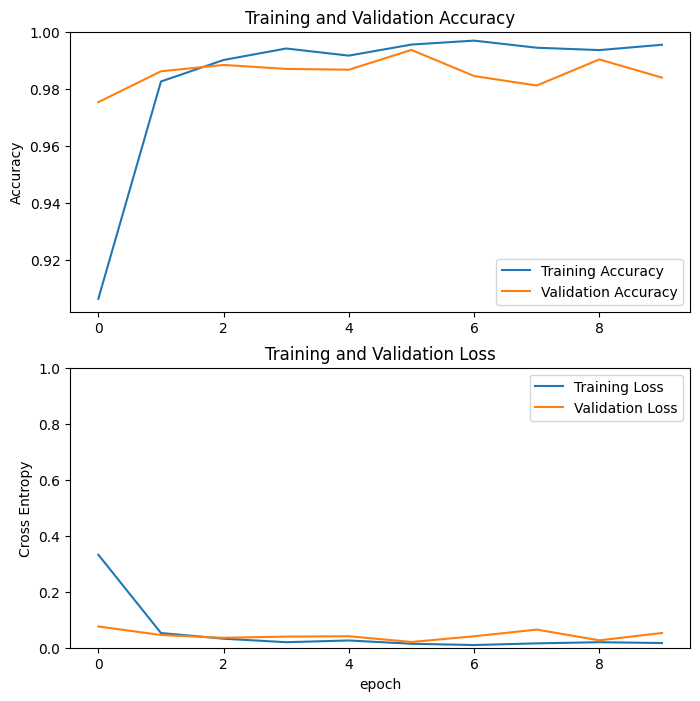

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [19]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


In [23]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=valid_generator,
                         validation_steps=len(valid_generator))

Epoch 1/5
452/452 [==============================] - 28s 58ms/step - loss: 0.2249 - accuracy: 0.9443 - val_loss: 0.0417 - val_accuracy: 0.9895
Epoch 2/5
452/452 [==============================] - 26s 57ms/step - loss: 0.0595 - accuracy: 0.9805 - val_loss: 0.0245 - val_accuracy: 0.9928
Epoch 3/5
452/452 [==============================] - 26s 57ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0199 - val_accuracy: 0.9933
Epoch 4/5
452/452 [==============================] - 26s 57ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0152 - val_accuracy: 0.9953
Epoch 5/5
452/452 [==============================] - 26s 57ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0164 - val_accuracy: 0.9956


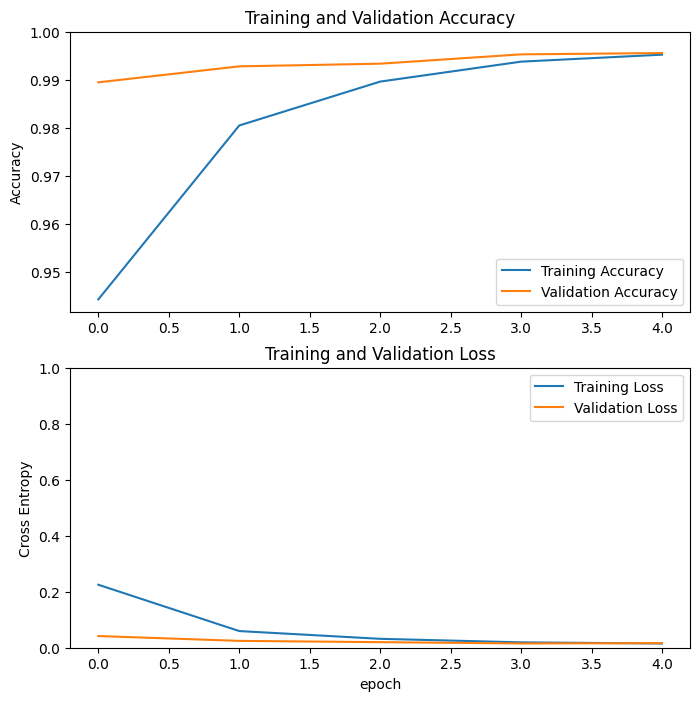

In [25]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
os.chdir("/home/jwjang/project_tf28/")

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpj43g8iho/assets


INFO:tensorflow:Assets written to: /tmp/tmpj43g8iho/assets
2022-10-28 21:20:56.725845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-10-28 21:20:56.725882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


In [31]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(IMAGE_PATH + '*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiw5cm70q/assets


INFO:tensorflow:Assets written to: /tmp/tmpiw5cm70q/assets
/home/jwjang/tf28/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-28 21:21:26.612079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-10-28 21:21:26.612112: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
